In [7]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv(r'C:\Users\DIPRAJ\Python_projects\Digital_twin_meters\Python\data\cleaned_df.csv', parse_dates=['Datetime'], index_col='Datetime')

In [11]:
data = df.iloc[:,:2]
data

,MeterA_ID,MeterA_reading
Datetime,,
2025-01-01 00:00:00,SMR89133A,0.391026
2025-01-01 01:00:00,SMR89134A,0.829049
2025-01-01 02:00:00,SMR89135A,1.301743
2025-01-01 03:00:00,SMR89136A,1.629477
2025-01-01 04:00:00,SMR89137A,1.987428
...,...,...
2025-07-29 20:00:00,SMR94144A,7146.926460
2025-07-29 21:00:00,SMR94145A,7150.075616
2025-07-29 22:00:00,SMR94146A,7150.377423


In [4]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['MeterA_reading'])
print('ADF Statistic:', result[0])
print('p-value:', result[1]) #>0.05

ADF Statistic: -0.8156842119360727
p-value: 0.8144714802279877


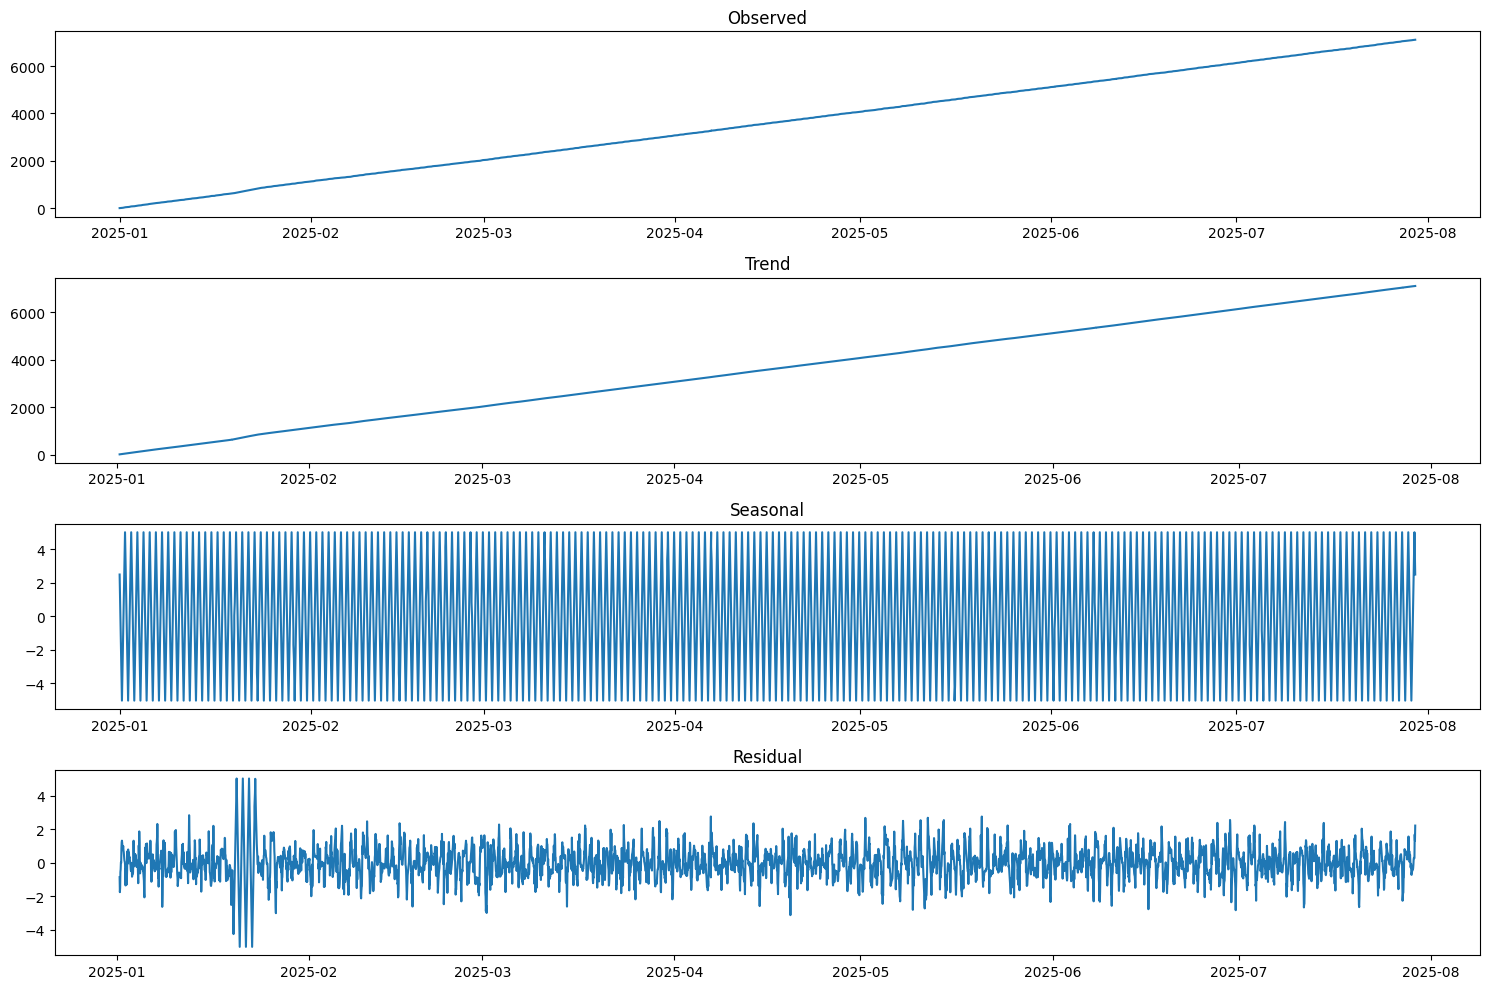

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

# For hourly data with daily seasonality, use period=24
decomp = seasonal_decompose(data["MeterA_reading"], model='additive', period=24)

plt.figure(figsize=(15, 10))  # Customize width and height

plt.subplot(411)
plt.plot(decomp.observed)
plt.title('Observed')

plt.subplot(412)
plt.plot(decomp.trend)
plt.title('Trend')

plt.subplot(413)
plt.plot(decomp.seasonal)
plt.title('Seasonal')

plt.subplot(414)
plt.plot(decomp.resid)
plt.title('Residual')

plt.tight_layout()
plt.show()


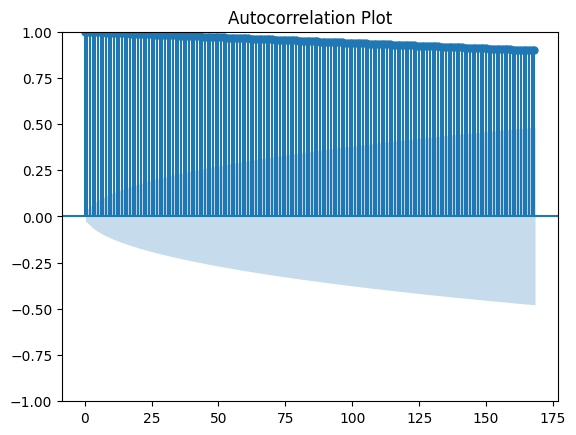

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data["MeterA_reading"], lags=168)  # Show up to 7 days of hourly lags
plt.title('Autocorrelation Plot')
plt.show()


# SARIMA Model

In [7]:
data_diff = data['MeterA_reading'].diff().dropna()
data_seasonal_diff = data_diff.diff(24).dropna()

<Axes: xlabel='Datetime'>

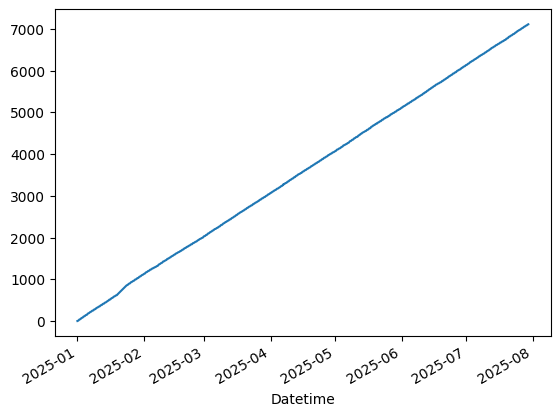

In [8]:
data["MeterA_reading"].plot()

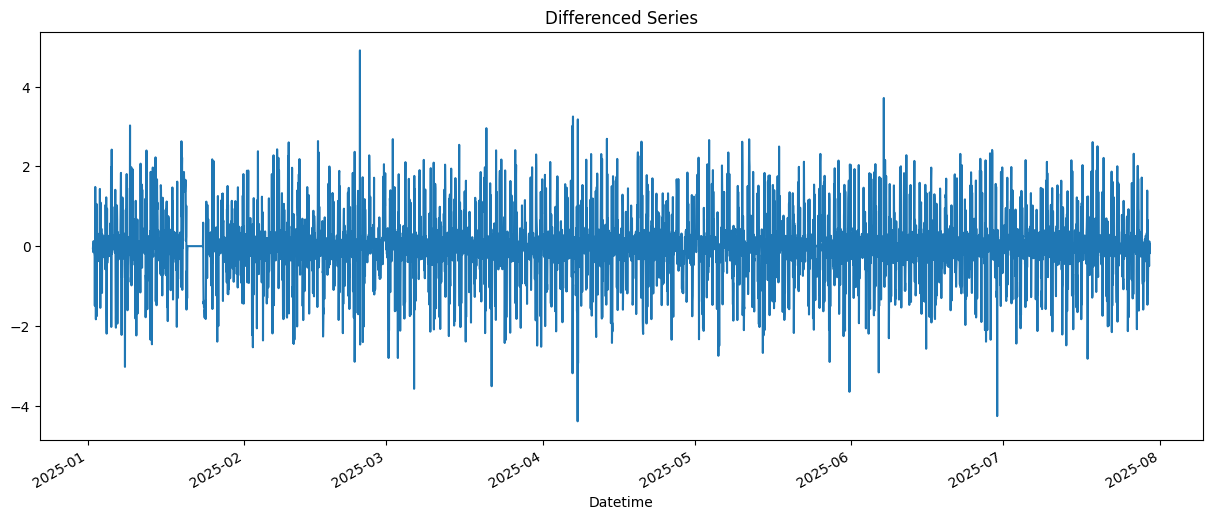

In [9]:
data_seasonal_diff.plot(figsize=(15,6))
plt.title("Differenced Series")
plt.show()

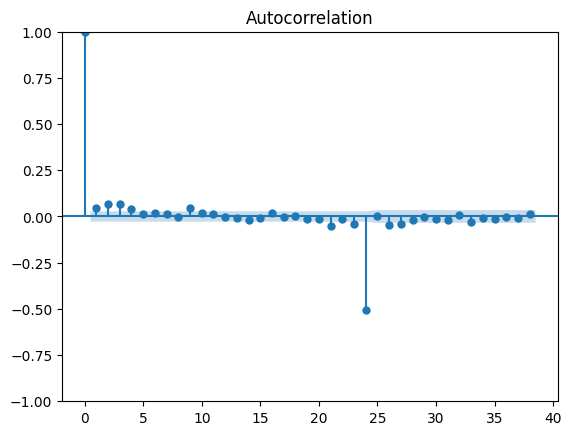

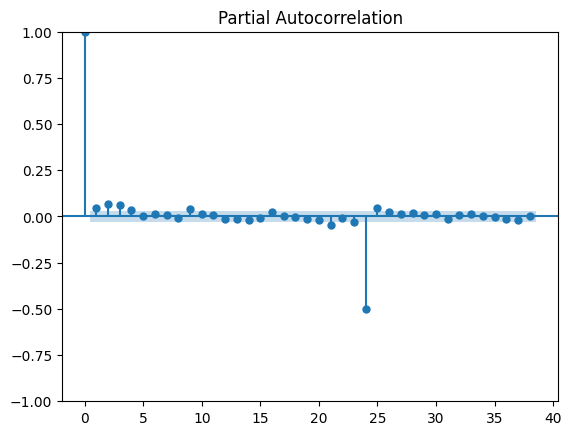

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_seasonal_diff)
plot_pacf(data_seasonal_diff)
plt.show()


In [16]:
def adf_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", round(dftest[1],6))
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
       print("\t",key, ": ", val)
    if dftest[0] < dftest[4]["5%"]:
        print ("Reject Ho - Time Series is Stationary")
    else:
        print ("Failed to Reject Ho - Time Series is Non-Stationary")

adf_test(data_seasonal_diff)

1. ADF :  -21.97397777014572
2. P-Value :  0.0
3. Num Of Lags :  25
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 4990
5. Critical Values :
	 1% :  -3.4316611557350547
	 5% :  -2.862119388798601
	 10% :  -2.5670784094039782
Reject Ho - Time Series is Stationary


## SARIMA Parameter Selection Explanation

In order to forecast time series data with seasonal patterns, we use the **Seasonal ARIMA (SARIMA)** model, which is denoted as:

``SARIMA(p, d, q)(P, D, Q, s)``

Where:
- **(p, d, q)** are the non-seasonal parameters:
  - **p**: Autoregressive order
  - **d**: Degree of differencing
  - **q**: Moving average order
- **(P, D, Q, s)** are the seasonal parameters:
  - **P**: Seasonal autoregressive order
  - **D**: Seasonal differencing
  - **Q**: Seasonal moving average order
  - **s**: Seasonal periodicity (number of time steps per season)

---

### Non-Seasonal Components (p, d, q):

- **d (order of differencing)**:
  From the plots, it appears that only seasonal differencing was applied, and it stabilized the mean. Therefore, the non-seasonal differencing order is:
  
  `d = 0`

- **q (MA order)**:
  The ACF plot shows a **significant spike at lag 1**, followed by a sharp drop and gradual decay. This pattern is typical of a Moving Average process of order 1:
  
  `q = 1`

- **p (AR order)**:
  The PACF plot shows a **strong spike at lag 1**, with subsequent lags near zero. This indicates an Autoregressive process of order 1:
  
  `p = 1`

---

### Seasonal Components (P, D, Q, s):

- **s (seasonal period)**:
  Both ACF and PACF plots show a strong negative spike at **lag 24**, suggesting a clear seasonal component with a 24-step cycle:
  
  `s = 24`

- **D (seasonal differencing)**:
  Since the data became stationary after seasonal differencing, the seasonal differencing order is:
  
  `D = 1`

- **Q (seasonal MA order)**:
  The ACF plot shows a **distinct negative spike at lag 24**, suggesting a seasonal MA component of order 1:
  
  `Q = 1`

- **P (seasonal AR order)**:
  The PACF plot also shows a **strong negative spike at lag 24**, indicating a seasonal AR component of order 1:
  
  `P = 1`

---

### ✅ Final Model Configuration

```python
SARIMA(p=1, d=0, q=1)(P=1, D=1, Q=1, s=24)


In [68]:
p,d,q = 3,1,1
P,D,Q,s = 1,1,2,24

In [69]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(data['MeterA_reading'], 
                order=(p, d, q), 
                seasonal_order=(P, D, Q, s), 
                enforce_stationarity=False, 
                enforce_invertibility=False)

results = model.fit()
print(results.summary())


c:\Users\DIPRAJ\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\DIPRAJ\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                        SARIMAX Results                                        
Dep. Variable:                          MeterA_reading   No. Observations:                 5041
Model:             SARIMAX(3, 1, 1)x(1, 1, [1, 2], 24)   Log Likelihood               -4440.309
Date:                                 Sun, 25 May 2025   AIC                           8896.618
Time:                                         11:03:48   BIC                           8948.701
Sample:                                              0   HQIC                          8914.878
                                                - 5041                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6260      0.095      6.587      0.000       0.440       0

In [73]:
n_past = 100
steps = 50
forecast = results.get_forecast(steps=steps)
forecast_ci = forecast.conf_int()


c:\Users\DIPRAJ\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [74]:
lower_bound = data['MeterA_reading'].to_list() + forecast_ci.iloc[:, 0].to_list()
upper_bound = data['MeterA_reading'].to_list() + forecast_ci.iloc[:, 1].to_list()

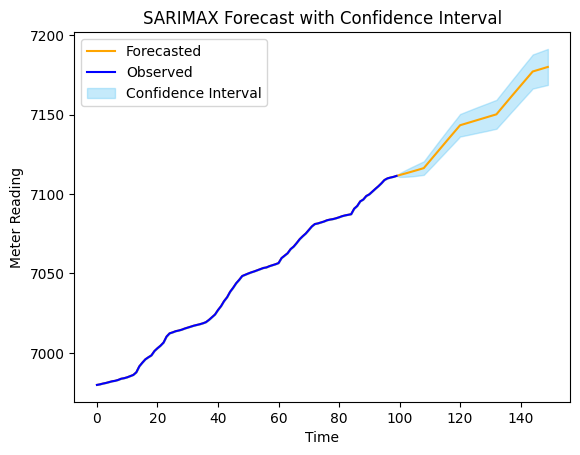

In [75]:
plt.plot(data['MeterA_reading'][-n_past:].to_list() + forecast.predicted_mean.to_list(), label='Forecasted', color='orange')
plt.plot(data['MeterA_reading'][-n_past:].to_list() + [np.nan] * steps, label='Observed', color='blue')
plt.fill_between(list(range(n_past + steps)), lower_bound[-(n_past + steps):], upper_bound[-(n_past + steps):], color='#42bcf5', alpha=0.3, label='Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Meter Reading')
plt.title('SARIMAX Forecast with Confidence Interval')
plt.legend()

## LSTM (Deep learning Approach)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'tensorflow'

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
# Reshape data for scaler (it expects 2D input: (num_samples, num_features))
scaled_data = scaler.fit_transform(data.iloc[:,1].to_numpy().reshape(-1,1))
print(f"Scaled data shape: {scaled_data.shape}")

Scaled data shape: (5041, 1)


In [24]:
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 48
X_sequences, y_targets = create_sequences(scaled_data, look_back)

In [26]:
X_sequences = X_sequences.reshape(X_sequences.shape[0], X_sequences.shape[1], 1)
X_sequences.shape

(4993, 48, 1)

In [29]:
print(f"\nCreated X_sequences shape: {X_sequences.shape} (samples, timesteps, features)")
print(f"Created y_targets shape: {y_targets.shape} (samples,)")


Created X_sequences shape: (4993, 48, 1) (samples, timesteps, features)
Created y_targets shape: (4993,) (samples,)


In [30]:
train_size = int(len(X_sequences) * 0.8)
X_train_np, X_test_np = X_sequences[0:train_size], X_sequences[train_size:len(X_sequences)]
y_train_np, y_test_np = y_targets[0:train_size], y_targets[train_size:len(y_targets)]

X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1).to(device) # Unsqueeze for (batch, 1) target
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(1).to(device) # Unsqueeze for (batch, 1) target

print(f"\nTrain X tensor shape: {X_train_tensor.shape}, Train y tensor shape: {y_train_tensor.shape}")
print(f"Test X tensor shape: {X_test_tensor.shape}, Test y tensor shape: {y_test_tensor.shape}")



Train X tensor shape: torch.Size([3994, 48, 1]), Train y tensor shape: torch.Size([3994, 1])
Test X tensor shape: torch.Size([999, 48, 1]), Test y tensor shape: torch.Size([999, 1])


In [31]:
class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super(QuantileLoss, self).__init__()
        self.quantiles = torch.tensor(quantiles, dtype=torch.float32).to(device)

    def forward(self, y_pred, y_true):
        """
        Quantile loss (pinball loss) for multiple quantiles.
        y_true: True target values (shape: [batch_size, 1])
        y_pred: Predicted quantile values (shape: [batch_size, num_quantiles])
        """
        assert y_true.shape[1] == 1, "y_true must have shape (batch_size, 1)"
        assert y_pred.shape[1] == len(self.quantiles), "y_pred must match num_quantiles"

        losses = []
        # Expand y_true to match the number of quantiles for broadcasting
        # y_true shape: (batch_size, 1) -> (batch_size, num_quantiles)
        y_true_expanded = y_true.expand_as(y_pred)

        errors = y_true_expanded - y_pred

        for i, q in enumerate(self.quantiles):
            # Select the errors for the current quantile
            errors_q = errors[:, i] # Shape (batch_size,)

            # Calculate loss for this quantile
            # loss = max(q * errors, (q - 1) * errors)
            loss_q = torch.where(errors_q >= 0, q * errors_q, (q - 1) * errors_q)
            losses.append(torch.mean(loss_q)) # Average loss for this quantile

        # Sum losses across all quantiles and average over the batch
        # The mean is already taken per quantile, so sum these means
        return torch.sum(torch.stack(losses))

# --- 4. LSTM Model Definition (PyTorch) ---
class LSTMQuantileModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMQuantileModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer: input_size, hidden_size, num_layers, batch_first=True
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # As per Keras's `activation='relu'` on LSTM, apply ReLU to the output of LSTM
        self.relu = nn.ReLU() 
        
        # Output layer mapping hidden_size to num_quantiles
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        # h0, c0 shape: (num_layers * num_directions, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        # out: (batch_size, sequence_length, hidden_size * num_directions)
        # hn, cn: (num_layers * num_directions, batch_size, hidden_size)
        out, (hn, cn) = self.lstm(x, (h0, c0))

        # We take the output from the last time step
        # out[:, -1, :]: (batch_size, hidden_size)
        out = self.relu(out[:, -1, :]) # Apply ReLU
        out = self.fc(out)             # Pass through linear layer
        return out

In [32]:
quantiles = [0.025, 0.5, 0.975]
num_quantiles = len(quantiles)

input_size = 1 # Number of features per timestep (our data is 1D)
hidden_size = 50 # Equivalent to 50 LSTM units in Keras
output_size = num_quantiles # Output for each quantile
num_layers = 1 # Keras default for LSTM is 1 layer if not specified

In [33]:
model = LSTMQuantileModel(input_size, hidden_size, output_size, num_layers=num_layers).to(device)

In [35]:
criterion = QuantileLoss(quantiles)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [36]:
print("\n--- Model Architecture ---")
print(model)


--- Model Architecture ---
LSTMQuantileModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (relu): ReLU()
  (fc): Linear(in_features=50, out_features=3, bias=True)
)


In [38]:
num_epochs = 200 # Increased epochs slightly, adjust as needed
batch_size = 32

In [39]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []

In [42]:
for epoch in range(num_epochs):
    model.train() # Set model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad() # Clear previous gradients
        loss.backward()       # Compute gradients
        optimizer.step()      # Update model parameters
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval() # Set model to evaluation mode
    val_running_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for validation
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_running_loss += loss.item()
    avg_val_loss = val_running_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

print("\n--- Training Finished ---")

Epoch [1/200], Train Loss: 0.1279, Val Loss: 0.0941
Epoch [10/200], Train Loss: 0.0034, Val Loss: 0.0294
Epoch [20/200], Train Loss: 0.0022, Val Loss: 0.0083
Epoch [30/200], Train Loss: 0.0024, Val Loss: 0.0072
Epoch [40/200], Train Loss: 0.0019, Val Loss: 0.0077
Epoch [50/200], Train Loss: 0.0018, Val Loss: 0.0072
Epoch [60/200], Train Loss: 0.0020, Val Loss: 0.0039
Epoch [70/200], Train Loss: 0.0016, Val Loss: 0.0080
Epoch [80/200], Train Loss: 0.0023, Val Loss: 0.0037
Epoch [90/200], Train Loss: 0.0013, Val Loss: 0.0088
Epoch [100/200], Train Loss: 0.0012, Val Loss: 0.0068
Epoch [110/200], Train Loss: 0.0016, Val Loss: 0.0064
Epoch [120/200], Train Loss: 0.0015, Val Loss: 0.0092
Epoch [130/200], Train Loss: 0.0012, Val Loss: 0.0037
Epoch [140/200], Train Loss: 0.0012, Val Loss: 0.0043
Epoch [150/200], Train Loss: 0.0011, Val Loss: 0.0022
Epoch [160/200], Train Loss: 0.0011, Val Loss: 0.0026
Epoch [170/200], Train Loss: 0.0012, Val Loss: 0.0020
Epoch [180/200], Train Loss: 0.0011, Va

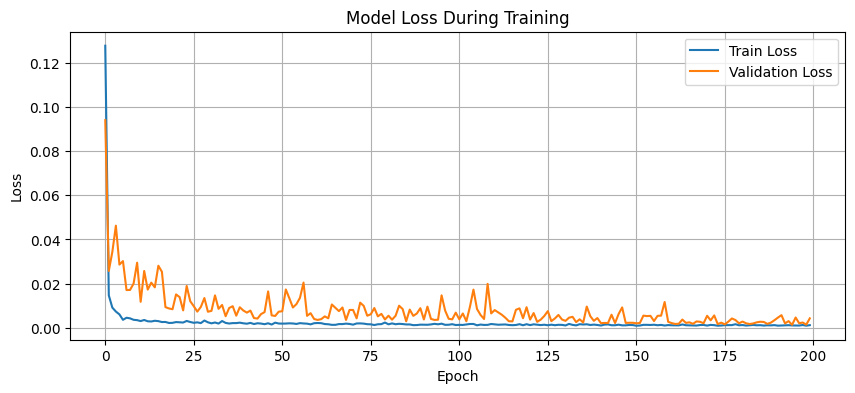

In [43]:
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
print("\n--- Making Predictions ---")
model.eval()


--- Making Predictions ---


LSTMQuantileModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (relu): ReLU()
  (fc): Linear(in_features=50, out_features=3, bias=True)
)

In [45]:
with torch.no_grad():
    # Ensure test data is on the correct device
    test_predictions_scaled_tensor = model(X_test_tensor)
    # Move to CPU and convert to NumPy array
    test_predictions_scaled = test_predictions_scaled_tensor.cpu().numpy()

print(f"Test predictions (scaled) shape: {test_predictions_scaled.shape}")

# Inverse transform the predictions back to the original scale
test_predictions_original_scale = np.zeros_like(test_predictions_scaled)
for i in range(num_quantiles):
    # Inverse transform each quantile column independently
    # Need to reshape to (num_samples, 1) for inverse_transform
    test_predictions_original_scale[:, i] = scaler.inverse_transform(test_predictions_scaled[:, i].reshape(-1, 1)).flatten()

# Get the true values in original scale for comparison
y_test_original_scale = scaler.inverse_transform(y_test_np.reshape(-1, 1)).flatten()


Test predictions (scaled) shape: (999, 3)


In [46]:
# Extract the quantiles for plotting
lower_bound = test_predictions_original_scale[:, 0]
median_prediction = test_predictions_original_scale[:, 1]
upper_bound = test_predictions_original_scale[:, 2]

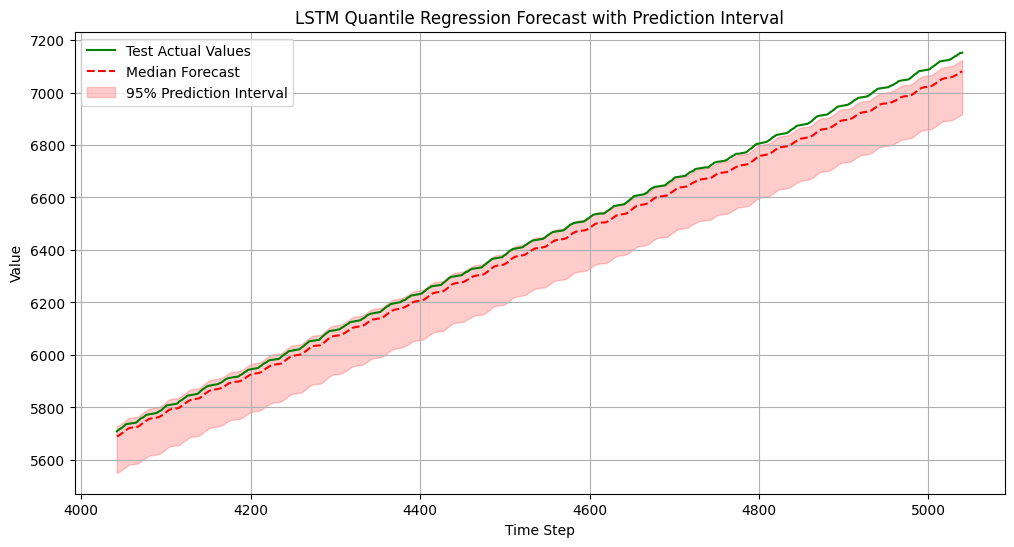

In [70]:
plt.figure(figsize=(12, 6))
train_actual_plot_end = len(data) - len(y_test_original_scale) # Or len(y_train_np) + look_back
# plt.plot(np.arange(look_back, train_actual_plot_end), data.iloc[look_back:train_actual_plot_end,1].to_numpy(), label='Train Actual Values', color='blue', alpha=0.7)
plt.plot(np.arange(train_actual_plot_end, len(data)), data.iloc[train_actual_plot_end:,1].to_numpy(), label='Test Actual Values', color='green')

plt.plot(np.arange(train_actual_plot_end, len(data)), median_prediction, label='Median Forecast', color='red', linestyle='--')

# Plot the confidence interval
plt.fill_between(
    np.arange(train_actual_plot_end, len(data)),
    lower_bound,
    upper_bound,
    color='red', alpha=0.2, label='95% Prediction Interval'
)

plt.title('LSTM Quantile Regression Forecast with Prediction Interval')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [71]:
import os
model_dir = "trained_models"
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, "lstm_quantile_model.pth")
scaler_path = os.path.join(model_dir, "minmax_scaler.joblib")
config_path = os.path.join(model_dir, "model_config.json") 

In [72]:
import joblib

torch.save(model.state_dict(), model_path)
print(f"PyTorch model saved to: {model_path}")

# Save the MinMaxScaler
joblib.dump(scaler, scaler_path)
print(f"MinMaxScaler saved to: {scaler_path}")

# Save model configuration (hyperparameters needed to rebuild the model)
import json
model_config = {
    "input_size": input_size,
    "hidden_size": hidden_size,
    "output_size": output_size,
    "num_layers": num_layers,
    "look_back": look_back,
    "quantiles": quantiles
}
with open(config_path, 'w') as f:
    json.dump(model_config, f, indent=4)
print(f"Model configuration saved to: {config_path}")

print("\nModel and scaler saved successfully. You can now run the API.")

PyTorch model saved to: trained_models\lstm_quantile_model.pth
MinMaxScaler saved to: trained_models\minmax_scaler.joblib
Model configuration saved to: trained_models\model_config.json

Model and scaler saved successfully. You can now run the API.


In [81]:
data.iloc[4000:4048, 1].to_numpy()

array([5656.60907774, 5658.46395621, 5659.74560776, 5662.16599598,
       5664.841106  , 5667.43828025, 5668.1220531 , 5668.87332584,
       5669.24143457, 5669.83668499, 5670.28969035, 5670.83567123,
       5671.13818936, 5671.73034913, 5672.21202074, 5672.95100605,
       5673.66275689, 5674.08069186, 5675.98790674, 5678.61774443,
       5680.21217159, 5683.6819839 , 5686.66702853, 5687.83807446,
       5689.76430395, 5691.46519223, 5693.51033886, 5695.28549305,
       5698.08708988, 5699.59085001, 5699.8965249 , 5700.52115906,
       5700.87942709, 5701.50964689, 5701.90998629, 5702.65023858,
       5703.35083343, 5704.08599454, 5704.81431002, 5705.47509783,
       5706.13855199, 5706.88795413, 5708.7837437 , 5711.04300377,
       5714.49423815, 5716.58762335, 5718.68841796, 5720.73834798])